In [ ]:
!pip install imageio
!pip install tqdm
!pip install pandas
!pip install scikit-image

In [1]:
import os
import zipfile
from six.moves import urllib


#load image dependencies
import sys
import scipy.io
import scipy.misc


import imageio

import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from keras.layers import BatchNormalization

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from tqdm import tqdm_notebook, trange

%matplotlib inline

Using TensorFlow backend.


# Download data

In [2]:
def fetch_data(url, path, file):
  if not os.path.isdir(path):
    os.makedirs(path)
  
  zip_path = os.path.join(path, file)
  urllib.request.urlretrieve(url, zip_path)
  zip_ref = zipfile.ZipFile(zip_path, 'r')
  zip_ref.extractall(path)
  zip_ref.close()
  
def load_data(path, file):
  csv_path = os.path.join(path, file)
  return pd.read_csv(csv_path)
  

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/willianmh/mc886/master/"
PATH = "data/salt"
URL = DOWNLOAD_ROOT + PATH + "/train.zip"
FILE = "train.zip"

fetch_data(URL, PATH, FILE)

# import images

In [4]:
# Set parameters
img_width = 128
img_height = 128
img_channels = 3
train_path = 'data/salt/images/'
mask_path = 'data/salt/masks/'


In [5]:
# Get train and test IDs
train_ids = os.listdir(train_path)



In [6]:
#Get train images and masks x
#Get train images and masks x


X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)


for n in range(len(train_ids)):
    img_id = train_ids[n]
    path = train_path + img_id
    img = imread(train_path + img_id )[:,:,:img_channels]
    img = resize(img, (img_height, img_width, 1), mode='constant', preserve_range=True)
    mask = imread(mask_path + img_id )[:,:]
    mask = resize(mask, (img_height, img_width, 1), mode='constant', preserve_range=True)
    X_train[n] = img
    Y_train[n] = mask


/home/pcmasterrace/miniconda2/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
def flip_dataset(dataset, mask):
    print("Espelhamento das amostras flip")
    dataset_size = len(dataset)
    new_dataset = np.zeros_like(dataset)
    new_mask = np.zeros_like(mask)
        
    
    for i in range(dataset_size):
        new_dataset[i] = np.flip(dataset[i], 1)
        new_mask[i] = np.flip(mask[i], 1)
        
    new_dataset = np.concatenate((dataset, new_dataset), axis=0)
    new_mask = np.concatenate((mask, new_mask), axis=0)
    
    return new_dataset, new_mask

In [8]:
X_train, Y_train = flip_dataset(X_train, Y_train)

Espelhamento das amostras flip


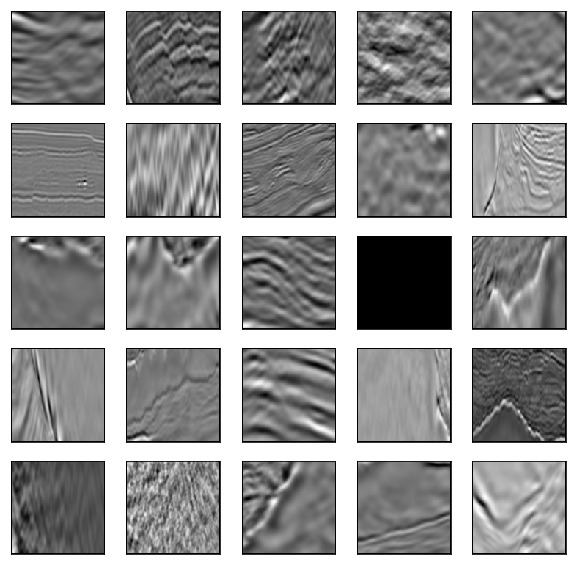

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)


# ARQUITETURA U-NET
---
Descomente as linhas, caso queira adicionar  
* camadas Batch Normalization
* camadas de Dropout (entre as camadas de convolução ou depois do maxpooling)

In [10]:
def u_net(img_height, img_width, img_chanels):
  # Build U-Net model
  inputs = Input((img_height, img_width, img_chanels))
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
#   c1 = Dropout(0.5) (c1)
  c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)
#   p1 = Dropout(0.2) (p1)

  c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
#   c2 = Dropout(0.5) (c2)
  c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)
#   p2 = Dropout(0.2) (p2)

  c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
#   c3 = Dropout(0.5) (c3)
  c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)
#   p3 = Dropout(0.2) (p3)

  c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
#   c4 = Dropout(0.5) (c4)
  c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
#   p4 = Dropout(0.2) (p4)

  c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
#   c5 = Dropout(0.5) (c5)
  c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

  u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
#   c6 = Dropout(0.5) (c6)
  c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

  u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
#   c7 = BatchNormalization(axis = 3, name = 'bn0')(c7)  # no parameters
#   c7 = Dropout(0.5) (c7)
  c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

  u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
#   c8 = Dropout(0.5) (c8)
  c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

  u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
#   c9 = BatchNormalization(axis = 3, name = 'bn1')(c9)  # no parameters
#   c9 = Dropout(0.5) (c9)
  c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Training U-Net
---
Descomente as linhas caso queira adicionar os pesos pretreinados da DSTL

In [ ]:
# What if we use pre-trained weights?
# This code illustrate how to segment the ROI in cervical images using U-NET.
# Well I'll find something more "normal", later

# Maybe this?
# Dstl Satellite Imagery Feature Detection: https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection
# !wget https://github.com/scottykwok/cervix-roi-segmentation-by-unet/releases/download/v1.0/weights.h5
# !wget https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/releases/download/v1.0/zf_unet_224.h5
!ls


In [ ]:
model = u_net(img_height, img_width, img_channels)
# model.load_weights('zf_unet_224.h5', by_name = True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics =[mean_iou])
model.summary()
model_name = 'u-net.h5'

In [ ]:
# Fit model
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs= 50, callbacks=[checkpointer, reduce_lr])

In [ ]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model mean iou')
plt.ylabel('mean iou')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Arquitetura UNET Backbone RESNET50

In [11]:
!pip install segmentation-models

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing


preprocessing_fn = get_preprocessing('resnet50')
X_train_resnet = preprocessing_fn(X_train)

# prepare model
model = Unet(backbone_name='resnet50', encoder_weights='imagenet')
# model.summary()
model.compile('Adam', 'binary_crossentropy', [mean_iou])

# train model
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
checkpointer = ModelCheckpoint('resnet.h5', verbose=1, save_best_only=True)
history = model.fit(X_train_resnet, Y_train, validation_split=0.1, batch_size=16, epochs= 50, callbacks=[checkpointer, reduce_lr])

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
# salva o summary() do grafo em PNG
!pip install pydot
from keras.utils.vis_utils import plot_model
graph = plot_model(model, to_file='meu_grafo.png', show_shapes=False)

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean iou')
plt.ylabel('mean iou')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# arquitetura UNET backbone RESNEXT50

In [ ]:
!pip install segmentation-models

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing


preprocessing_fn = get_preprocessing('resnext50')
X_train_resnext = preprocessing_fn(X_train)

# prepare model
model = Unet(backbone_name='resnext50', encoder_weights='imagenet')
# model.summary()
model.compile('Adam', 'binary_crossentropy', [mean_iou])

# train model
checkpointer = ModelCheckpoint('resnext.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
history = model.fit(X_train_resnext, Y_train, validation_split=0.1, batch_size=16, epochs= 50, callbacks=[checkpointer, reduce_lr])

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean iou')
plt.ylabel('mean iou')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test

In [ ]:
!ls

In [ ]:
!unzip test.zip

In [ ]:
# Get and resize test images
test_ids = next(os.walk('images/'))[2]
X_test = np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    img = load_img('images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

In [ ]:
# Predict on train, val and test
model_name = 'resnet.h5'
model = load_model(model_name, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:


# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

# Submission CSV to KAGGLE

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in enumerate(test_ids)}

In [ ]:
submission_file = model_name

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file + '.csv')

In [ ]:
model.summary()

# Referências

#### introduction to seismic/unet
https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics

#### siraj livestream
https://github.com/llSourcell/Kaggle_Challenge_LIVE/blob/master/salt_identification.ipynb

#### Pesos para U-Net
https://github.com/scottykwok/cervix-roi-segmentation-by-unet/releases

=D